# PyTorch实践_Fashion MNIST

## Fashion-MNIST介绍

我们在神经网络介绍中，通过CNN对MNIST数据集做了分类实践，MNIST是做什么的呢？

经典的 MNIST 数据集包含了大量的手写数字。十几年来，来自机器学习、机器视觉、人工智能、深度学习领域的研究员们把这个数据集作为衡量算法的基准之一。你会在很多的会议，期刊的论文中发现这个数据集的身影。实际上，MNIST 数据集已经成为算法作者的必测的数据集之一。有人曾调侃道：" 如果一个算法在 MNIST 不 work, 那么它就根本没法用；而如果它在 MNIST 上 work, 它在其他数据上也可能不 work！"

<img src='./image/mnist.png' />

但是对于MNIST的诟病也有很多：

>MNIST 太简单了，很多算法在测试集上的性能已经达到 99.6%！不妨看看我们基于 scikit-learn 上对经典机器学习算法的评测 和这段代码： "Most pairs of MNIST digits can be distinguished pretty well by just one pixel"（翻译：大多数 MNIST 只需要一个像素就可以区分开！）

>MNIST 被用烂了。参考："Ian Goodfellow wants people to move away from mnist"（翻译：Ian Goodfellow 希望人们不要再用 MNIST 了。）

>MNIST 数字识别的任务不代表现代机器学习。参考："Fran ç ois Cholle: Ideas on MNIST do not transfer to real CV" （翻译：在 MNIST 上看似有效的想法没法迁移到真正的机器视觉问题上。）

FashionMNIST 是一个替代 MNIST 手写数字集的图像数据集。 它是由 Zalando（一家德国的时尚科技公司）旗下的研究部门提供。其涵盖了来自 10 种类别的共 7 万个不同商品的正面图片。FashionMNIST 的大小、格式和训练集 / 测试集划分与原始的 MNIST 完全一致。60000/10000 的训练测试数据划分，28x28 的灰度图片。你可以直接用它来测试你的机器学习和深度学习算法性能，且不需要改动任何的代码。

简单来说：
Fashion-MNIST 的目的是要成为 MNIST 数据集的一个直接替代品。作为算法作者，你不需要修改任何的代码，就可以直接使用这个数据集。Fashion-MNIST 的图片大小，训练、测试样本数及类别数与经典 MNIST 完全相同。

相关文章：[连 LeCun 都推荐的 Fashion-MNIST 数据集，是这位华人博士的成果](http://app.myzaker.com/news/article.php?pk=59a3e2ebd1f149c0130000fb)

具体GitHub的链接：[fashion-mnist](https://github.com/zalandoresearch/fashion-mnist)

Fashion-MNIST的示意图：
<img src='./image/fashion-mnist-sprite.png' />

## 相关文件下载

其GitHub有下载地址：
<img src='./image/fmdl.png' />

将这四个文件下载下来，并解压，得到4个没有扩展名的二进制文件，train开头的文件是训练集，t10k开头的文件是测试集。

一会我们将图像以及分类标签，从这四个文件拆分出来。

Fashion-MNIST的标签如下：
<img src='./image/fmlabel.png' />

之后，将下载的fashion-mnist的压缩包，解压到合适目录，如```./pytorchdata_fashionmnist```：
<img src='./image/fmpath.png' />

其中没有扩展名的二进制文件是我们的训练集以及测试集；

train与test文件夹是提取的图片文件保存路径，每个文件都是```28*28```的图片

train.txt与test.txt是图片与label的mapping信息，如：

```
./data/train/0.jpg 9
./data/train/1.jpg 0
```

## 通过PyTorch训练CNN模型

下面我们开工，通过PyTorch制作一个CNN网络

导入需要的组件包

skimage的目的，是将fashion-mnist的图片二进制数据，保存为图片文件到本地

In [1]:
import os
from skimage import io
import torchvision.datasets.mnist as mnist
import torch
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn
from PIL import Image
import matplotlib.pyplot as plt
import re

设置fashion-mnist的相关数据文件目录

In [2]:
root = './pytorchdata_fashionmnist/'
if not os.path.exists(root):
    os.makedirs(root)

定义图像转换函数

- 图像二进制与图像分类标签，是配对的:
<br>训练集文件为：train-image-idx3-ubyte与train-labels-idx1-ubyte
<br>测试集文件为：t10k-image-idx3-ubyte与t10k-labels-idx1-ubyte

- 训练集有60000张图片

- 测试集有10000张图片

- 通过mnist.read_image_file函数，读取图像二进制数据

- 通过mnist.read_label_file函数，读取标签数据

In [3]:
def convert_to_img():
    convertdict = {'train': 'train.txt_train', 'test': 'test.txt_t10k'}
    for key, value in convertdict.items():
        txtfile = value.split('_')[0]
        if os.path.exists(os.path.join(root, txtfile)):
            print('{0} data has been stored!'.format(key))
            continue
        imagepre = value.split('_')[1]
        dataset = (mnist.read_image_file(os.path.join(root,
                                                      '{0}-images-idx3-ubyte'.format(imagepre))),
                   mnist.read_label_file(os.path.join(root,
                                                      '{0}-labels-idx1-ubyte'.format(imagepre))))
        print('{0} set size: {1}'.format(key, dataset[0].size()))
        with open(os.path.join(root, txtfile), 'w', encoding='utf-8') as file:
            data_path = os.path.join(root, key)
            if not os.path.exists(data_path):
                os.makedirs(data_path)
            print('Save {0} image file begin'.format(key))
            for i, (img, label) in enumerate(zip(dataset[0], dataset[1])):
                print('save image file: {0}'.format(i + 1))
                img_path = os.path.join(data_path,
                                        str(i) + '.jpg').replace('\\', '/')
                io.imsave(img_path, img.numpy())
                labelnumlist = re.findall(r'\d+', str(label))
                if len(labelnumlist) > 0:
                    file.write(img_path + ' ' + str(labelnumlist[0]) + '\n')
            print('Save {0} image file end'.format(key))

通过PIL的Image模块，将图片加载并转为RGB三通道

In [4]:
def default_loader(path):
    return Image.open(path).convert('RGB')

继承torch.utils.data中的Dataset类，作为定制化的数据集生成类，其中target_transform一般为torchvision包的transforms模块的ToTensor类

In [5]:
class MyDataset(Dataset):
    def __init__(self, txt, transform=None, target_transform=None, loader=default_loader):
        with open(txt, 'r', encoding='utf-8') as fh:
            imgs = []
            for line in fh:
                line = line.strip('\n')
                line = line.rstrip()
                words = line.split()
                imgs.append((words[0], int(words[1])))
            self.imgs = imgs
            self.transform = transform
            self.target_transform = target_transform
            self.loader = loader

    def __getitem__(self, index):
        fn, label = self.imgs[index]
        img = self.loader(fn)
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.imgs)

定义CNN神经网络

- 继承自torch.nn.Module

- 共3个卷积层，每个卷积层都有窗口大小与步长为2的池化层，使用ReLU作为卷积层激活函数

- 一个输出层，进行10分类

In [6]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 3, 1, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, 3, 1, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, 3, 1, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.dense = torch.nn.Sequential(
            torch.nn.Linear(64 * 3 * 3, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10)
        )

    def forward(self, x):
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(conv1_out)
        conv3_out = self.conv3(conv2_out)
        res = conv3_out.view(conv3_out.size(0), -1)
        out = self.dense(res)
        return out

PyTorch可以通过torch.cuda.is_available()的函数判断当前系统是否支持GPU，从而可以自适应选择GPU或CPU

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


初始化模型的方法

- ```mymodel.to(device)```, 这一句即做到模型训练自适应（选择GPU或CPU）

In [8]:
def initialmodel():
    mymodel = Net()
    mymodel = mymodel.to(device)
    if device == 'cuda':
        mymodel = torch.nn.DataParallel(mymodel)
        cudnn.benchmark = True
    return mymodel

模型训练方法

- epochcount，代表训练多少次
- resume，代表是否接着之前训练完毕的模型继续训练
- 首先通过MyDataset类，加载训练集，并且设置transforms.ToTensor()作为transform方法
- PyTorch要求必须按照mini-batch的方式进行训练
- 通过DataLoader加载训练集，设置每个批次为64条数据，shuffle=True，代表将训练集随机打散
- 优化函数，选择Adam (torch.optim.Adam)
- 损失函数，选择交叉熵 (torch.nn.CrossEntropyLoss)
- 必须通过model变量.train()的方式，声明：要开始训练了
- 前向传播结束之后，需要通过optimizer.zero_grad()，是把梯度置零，也就是把loss关于weight的导数变成0。
>原因：根据pytorch中的backward()函数的计算，当网络参量进行反馈时，梯度是被积累的而不是被替换掉；但是在每一个batch时毫无疑问并不需要将两个batch的梯度混合起来累积，因此这里就需要每个batch设置一遍zero_grad 了。

In [9]:
def train(epochcount=10, resume=True):
    train_data = MyDataset(txt=os.path.join(root, 'train.txt'), transform=transforms.ToTensor())
    train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
    startepoch = 0
    if resume:
        mymodel, startepoch = loadmodel()
        if startepoch >= epochcount:
            print('The epoch of trained model is {0}, greater than epoch count: {1}, need not train it!'.
                  format(startepoch, epochcount))
    else:
        mymodel = initialmodel()
    print(mymodel)
    # 优化函数，选择Adam
    optimizer = torch.optim.Adam(mymodel.parameters())
    # 损失函数，选择交叉熵
    loss_func = torch.nn.CrossEntropyLoss()
    # 设置checkpoint的模型存放路径
    modelfolder = os.path.join(os.path.join(root, 'model'))
    if not os.path.exists(modelfolder):
        os.makedirs(modelfolder)
    modelfile = os.path.join(modelfolder, 'fashionmnist.pt')
    for epoch in range(startepoch, epochcount):
        print('epoch {}'.format(epoch + 1))
        # 必须通过model变量.train()的方式，声明：要开始训练了
        mymodel.train()
        # training-----------------------------
        train_loss = 0.
        train_acc = 0.
        best_acc = 0
        for i, (batch_x, batch_y) in enumerate(train_loader):
            print('Train epoch:{0} iter: {1} begin'.format(epoch, i + 1))
            # 自适应训练数据是否支持GPU
            batch_x, batch_y = Variable(batch_x.to(device)), Variable(batch_y.to(device))
            out = mymodel(batch_x)
            # 动态更新loss与accuracy的数量
            loss = loss_func(out, batch_y)
            train_loss += loss.data.item()
            pred = torch.max(out, 1)[1]
            # 通过torch.sum统计预测正确的数量
            train_correct = torch.sum(pred == batch_y)
            # train_correct是Tensor类型，需要通过item()，得到数值
            train_acc += train_correct.item()
            # optimizer.zero_grad()意思是把梯度置零，也就是把loss关于weight的导数变成0
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print('Train epoch:{0} iter: {1} end'.format(epoch, i + 1))
        accrate = train_acc / (len(train_data))
        # 输出每个epoch的损失率与准确率
        print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss / (len(train_data)), accrate))
        # 如果当前epoch的准确率是最高的，则保存模型。
        # 模型的权重信息是通过state_dict()获得的，这也是模型的最关键信息
        if accrate > best_acc:
            print('save model for best accuate: {0} begin'.format(accrate))
            best_acc = accrate
            torch.save({
                'epoch': epoch + 1,
                'state_dict': mymodel.state_dict(),
                'best_acc': best_acc,
            }, modelfile)
            print('save model for best accuate: {0} end'.format(accrate))

加载模型
- 如果模型不存在，则返回初始化的模型
- 否则，加载模型，主要是加载state_dict信息

In [10]:
def loadmodel():
    modelfolder = os.path.join(os.path.join(root, 'model'))
    modelfile = os.path.join(modelfolder, 'fashionmnist.pt')
    if not os.path.exists(modelfile):
        print('model not exist!')
        return initialmodel(), 0
    print('Loading best model: {0} begin'.format(modelfile))
    mymodel = initialmodel()
    checkpoint = torch.load(modelfile)
    epoch = checkpoint['epoch']
    best_acc = checkpoint['best_acc']
    mymodel.load_state_dict(checkpoint['state_dict'])
    print('Loading best model end, epoch is {0}, training accuracy is {1}'.format(epoch, best_acc))
    return mymodel, epoch

测试模型

- 测试集加载与训练集加载方式是一样的
- 必须调用model变量.evel()方法，以便在运行推断之前将dropout和batch规范化层设置为评估模式。如果不这样做，将会产生不一致的推断结果。
- 评估过程中需要加入：with torch.no_grad()，适用于推断阶段，不需要反向传播
- 评估的过程与训练过程自评估方式是一样的

In [11]:
def test():
    test_data = MyDataset(txt=os.path.join(root, 'test.txt'), transform=transforms.ToTensor())
    test_loader = DataLoader(dataset=test_data, batch_size=64)
    mymodel, epoch = loadmodel()
    if epoch == 0:
        print('Model not be trainned!')
        return
    # 您必须调用model.eval()，
    # 以便在运行推断之前将dropout和batch规范化层设置为评估模式。
    # 如果不这样做，将会产生不一致的推断结果。
    mymodel.eval()
    eval_loss = 0.
    eval_acc = 0.
    loss_func = torch.nn.CrossEntropyLoss()
    # 适用于推断阶段，不需要反向传播
    with torch.no_grad():
        for i, (batch_x, batch_y) in enumerate(test_loader):
            print('Validate iter: {0} begin'.format(i + 1))
            batch_x, batch_y = Variable(batch_x.to(device)), Variable(batch_y.to(device))
            out = mymodel(batch_x)
            loss = loss_func(out, batch_y)
            eval_loss += loss.data.item()
            pred = torch.max(out, 1)[1]
            num_correct = torch.sum(pred == batch_y)
            eval_acc += num_correct.item()
            print('Validate iter: {0} end'.format(i + 1))
        print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(test_data)), eval_acc / (len(test_data))))


测试用户自己的图片文件
- 这种使用方式，即模拟真实业务场景的数据分类预测
- torch.unsqueeze()，因为PyTorch训练模式只有mini-batch，所以哪怕对用户的某个图像进行预测，依然需要将其作为一个数量为1的batch，即将单张图片的：```[3, 28, 28]```转为```[1, 3, 28, 28]```。代码中有更详细的注释
>torch.unsqueeze(),这个函数主要是对数据维度进行扩充。给指定位置加上维数为一的维度，比如原本有个三行的数据（3），在0的位置加了一维就变成一行三列（1,3）

In [12]:
def  preprocess(imgfile):
    """
    图像预处理
    1. 读取图像并转为RGB 3通道
    2. 图片大小转为28x28
    :param imgfile:
    :return:
    """
    # Image转为灰度，通过convert('L')完成，但是fashion-mnist图片已经都是灰度了，没有必要先转灰度
    # 灰色图像的每个像素用8个bit表示，0表示黑，255表示白，其他数字表示不同的灰度。
    # 在PIL中，从模式“RGB”转换为“L”模式是按照下面的公式转换的：
    # L = R * 0.299 + G * 0.587+ B * 0.114
    # image = Image.open(imgfile).convert('L').convert('RGB')
    # 直接转为RGB通道
    image = Image.open(imgfile).convert('RGB')
    # 尺寸大小统一为28x28
    image = image.resize((28, 28))
    return image

In [13]:
def validateuserdata():
    imgfile = os.path.join(root, 'train/80.jpg')
    category = 1
    image = preprocess(imgfile)
    plt.figure("fashion-mnist")
    plt.imshow(image)
    plt.show()
    img = transforms.ToTensor()(image)
    print('load image file: {0}, category: {1} success'.format(imgfile, category))
    mymodel, epoch = loadmodel()
    mymodel.eval()

    with torch.no_grad():
        datax = img.to(device)
        # 如果直接将datax，作为参数去预测分类，会遇到如下错误：
        # RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 3, 3],
        # but got 3-dimensional input of size [3, 28, 28] instead
        # 因为torch.nn仅仅支持mini-batches, 预测的输入数据应该符合: (batch_size, channels, height, width)
        # 上述异常，是遗失batch dimension引起的。
        # 最简单的方法是通过：datax.unsqueeze(0)，即使其变成[1, 3, 28, 28]的4-dimensions数据
        print('Shape before Transorm: {0}'.format(datax.size()))
        print('Channel: {0}, Width: {1}, Height: {2}'.format(datax.size()[0], datax.size()[1], datax.size()[2]))
        datax = datax.unsqueeze(0)
        print('Shape after Transorm: {0}'.format(datax.size()))
        out = mymodel(datax)
        pred = torch.max(out, 1)[1]
        print(pred, pred.item())

实际操作：包括提炼图片，训练模型，对测试集进行验证以及预测单个用户图片分类

In [18]:
print('Convert image begin')
convert_to_img()
print('Convert image end')
print()
print('Train model begin')
train(epochcount=20, resume=True)
print('Train model end')
print()
print('Test model begin')
test()
print('Test model end')
print()
print('Validate user data begin')

Convert image begin
train data has been stored!
test data has been stored!
Convert image end

Train model begin
Loading best model: ./pytorchdata_fashionmnist/model\fashionmnist.pt begin
Loading best model end, epoch is 10, training accuracy is 0.9507333333333333
DataParallel(
  (module): Net(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (dense): Sequential(
      (0): Linear(in_features=576, out_featur

Train epoch:10 iter: 258 end
Train epoch:10 iter: 259 begin
Train epoch:10 iter: 259 end
Train epoch:10 iter: 260 begin
Train epoch:10 iter: 260 end
Train epoch:10 iter: 261 begin
Train epoch:10 iter: 261 end
Train epoch:10 iter: 262 begin
Train epoch:10 iter: 262 end
Train epoch:10 iter: 263 begin
Train epoch:10 iter: 263 end
Train epoch:10 iter: 264 begin
Train epoch:10 iter: 264 end
Train epoch:10 iter: 265 begin
Train epoch:10 iter: 265 end
Train epoch:10 iter: 266 begin
Train epoch:10 iter: 266 end
Train epoch:10 iter: 267 begin
Train epoch:10 iter: 267 end
Train epoch:10 iter: 268 begin
Train epoch:10 iter: 268 end
Train epoch:10 iter: 269 begin
Train epoch:10 iter: 269 end
Train epoch:10 iter: 270 begin
Train epoch:10 iter: 270 end
Train epoch:10 iter: 271 begin
Train epoch:10 iter: 271 end
Train epoch:10 iter: 272 begin
Train epoch:10 iter: 272 end
Train epoch:10 iter: 273 begin
Train epoch:10 iter: 273 end
Train epoch:10 iter: 274 begin
Train epoch:10 iter: 274 end
Train epoch

Train epoch:10 iter: 531 end
Train epoch:10 iter: 532 begin
Train epoch:10 iter: 532 end
Train epoch:10 iter: 533 begin
Train epoch:10 iter: 533 end
Train epoch:10 iter: 534 begin
Train epoch:10 iter: 534 end
Train epoch:10 iter: 535 begin
Train epoch:10 iter: 535 end
Train epoch:10 iter: 536 begin
Train epoch:10 iter: 536 end
Train epoch:10 iter: 537 begin
Train epoch:10 iter: 537 end
Train epoch:10 iter: 538 begin
Train epoch:10 iter: 538 end
Train epoch:10 iter: 539 begin
Train epoch:10 iter: 539 end
Train epoch:10 iter: 540 begin
Train epoch:10 iter: 540 end
Train epoch:10 iter: 541 begin
Train epoch:10 iter: 541 end
Train epoch:10 iter: 542 begin
Train epoch:10 iter: 542 end
Train epoch:10 iter: 543 begin
Train epoch:10 iter: 543 end
Train epoch:10 iter: 544 begin
Train epoch:10 iter: 544 end
Train epoch:10 iter: 545 begin
Train epoch:10 iter: 545 end
Train epoch:10 iter: 546 begin
Train epoch:10 iter: 546 end
Train epoch:10 iter: 547 begin
Train epoch:10 iter: 547 end
Train epoch

Train epoch:10 iter: 804 end
Train epoch:10 iter: 805 begin
Train epoch:10 iter: 805 end
Train epoch:10 iter: 806 begin
Train epoch:10 iter: 806 end
Train epoch:10 iter: 807 begin
Train epoch:10 iter: 807 end
Train epoch:10 iter: 808 begin
Train epoch:10 iter: 808 end
Train epoch:10 iter: 809 begin
Train epoch:10 iter: 809 end
Train epoch:10 iter: 810 begin
Train epoch:10 iter: 810 end
Train epoch:10 iter: 811 begin
Train epoch:10 iter: 811 end
Train epoch:10 iter: 812 begin
Train epoch:10 iter: 812 end
Train epoch:10 iter: 813 begin
Train epoch:10 iter: 813 end
Train epoch:10 iter: 814 begin
Train epoch:10 iter: 814 end
Train epoch:10 iter: 815 begin
Train epoch:10 iter: 815 end
Train epoch:10 iter: 816 begin
Train epoch:10 iter: 816 end
Train epoch:10 iter: 817 begin
Train epoch:10 iter: 817 end
Train epoch:10 iter: 818 begin
Train epoch:10 iter: 818 end
Train epoch:10 iter: 819 begin
Train epoch:10 iter: 819 end
Train epoch:10 iter: 820 begin
Train epoch:10 iter: 820 end
Train epoch

Train epoch:11 iter: 140 begin
Train epoch:11 iter: 140 end
Train epoch:11 iter: 141 begin
Train epoch:11 iter: 141 end
Train epoch:11 iter: 142 begin
Train epoch:11 iter: 142 end
Train epoch:11 iter: 143 begin
Train epoch:11 iter: 143 end
Train epoch:11 iter: 144 begin
Train epoch:11 iter: 144 end
Train epoch:11 iter: 145 begin
Train epoch:11 iter: 145 end
Train epoch:11 iter: 146 begin
Train epoch:11 iter: 146 end
Train epoch:11 iter: 147 begin
Train epoch:11 iter: 147 end
Train epoch:11 iter: 148 begin
Train epoch:11 iter: 148 end
Train epoch:11 iter: 149 begin
Train epoch:11 iter: 149 end
Train epoch:11 iter: 150 begin
Train epoch:11 iter: 150 end
Train epoch:11 iter: 151 begin
Train epoch:11 iter: 151 end
Train epoch:11 iter: 152 begin
Train epoch:11 iter: 152 end
Train epoch:11 iter: 153 begin
Train epoch:11 iter: 153 end
Train epoch:11 iter: 154 begin
Train epoch:11 iter: 154 end
Train epoch:11 iter: 155 begin
Train epoch:11 iter: 155 end
Train epoch:11 iter: 156 begin
Train epo

Train epoch:11 iter: 413 begin
Train epoch:11 iter: 413 end
Train epoch:11 iter: 414 begin
Train epoch:11 iter: 414 end
Train epoch:11 iter: 415 begin
Train epoch:11 iter: 415 end
Train epoch:11 iter: 416 begin
Train epoch:11 iter: 416 end
Train epoch:11 iter: 417 begin
Train epoch:11 iter: 417 end
Train epoch:11 iter: 418 begin
Train epoch:11 iter: 418 end
Train epoch:11 iter: 419 begin
Train epoch:11 iter: 419 end
Train epoch:11 iter: 420 begin
Train epoch:11 iter: 420 end
Train epoch:11 iter: 421 begin
Train epoch:11 iter: 421 end
Train epoch:11 iter: 422 begin
Train epoch:11 iter: 422 end
Train epoch:11 iter: 423 begin
Train epoch:11 iter: 423 end
Train epoch:11 iter: 424 begin
Train epoch:11 iter: 424 end
Train epoch:11 iter: 425 begin
Train epoch:11 iter: 425 end
Train epoch:11 iter: 426 begin
Train epoch:11 iter: 426 end
Train epoch:11 iter: 427 begin
Train epoch:11 iter: 427 end
Train epoch:11 iter: 428 begin
Train epoch:11 iter: 428 end
Train epoch:11 iter: 429 begin
Train epo

Train epoch:11 iter: 686 begin
Train epoch:11 iter: 686 end
Train epoch:11 iter: 687 begin
Train epoch:11 iter: 687 end
Train epoch:11 iter: 688 begin
Train epoch:11 iter: 688 end
Train epoch:11 iter: 689 begin
Train epoch:11 iter: 689 end
Train epoch:11 iter: 690 begin
Train epoch:11 iter: 690 end
Train epoch:11 iter: 691 begin
Train epoch:11 iter: 691 end
Train epoch:11 iter: 692 begin
Train epoch:11 iter: 692 end
Train epoch:11 iter: 693 begin
Train epoch:11 iter: 693 end
Train epoch:11 iter: 694 begin
Train epoch:11 iter: 694 end
Train epoch:11 iter: 695 begin
Train epoch:11 iter: 695 end
Train epoch:11 iter: 696 begin
Train epoch:11 iter: 696 end
Train epoch:11 iter: 697 begin
Train epoch:11 iter: 697 end
Train epoch:11 iter: 698 begin
Train epoch:11 iter: 698 end
Train epoch:11 iter: 699 begin
Train epoch:11 iter: 699 end
Train epoch:11 iter: 700 begin
Train epoch:11 iter: 700 end
Train epoch:11 iter: 701 begin
Train epoch:11 iter: 701 end
Train epoch:11 iter: 702 begin
Train epo

Train epoch:12 iter: 19 begin
Train epoch:12 iter: 19 end
Train epoch:12 iter: 20 begin
Train epoch:12 iter: 20 end
Train epoch:12 iter: 21 begin
Train epoch:12 iter: 21 end
Train epoch:12 iter: 22 begin
Train epoch:12 iter: 22 end
Train epoch:12 iter: 23 begin
Train epoch:12 iter: 23 end
Train epoch:12 iter: 24 begin
Train epoch:12 iter: 24 end
Train epoch:12 iter: 25 begin
Train epoch:12 iter: 25 end
Train epoch:12 iter: 26 begin
Train epoch:12 iter: 26 end
Train epoch:12 iter: 27 begin
Train epoch:12 iter: 27 end
Train epoch:12 iter: 28 begin
Train epoch:12 iter: 28 end
Train epoch:12 iter: 29 begin
Train epoch:12 iter: 29 end
Train epoch:12 iter: 30 begin
Train epoch:12 iter: 30 end
Train epoch:12 iter: 31 begin
Train epoch:12 iter: 31 end
Train epoch:12 iter: 32 begin
Train epoch:12 iter: 32 end
Train epoch:12 iter: 33 begin
Train epoch:12 iter: 33 end
Train epoch:12 iter: 34 begin
Train epoch:12 iter: 34 end
Train epoch:12 iter: 35 begin
Train epoch:12 iter: 35 end
Train epoch:12

Train epoch:12 iter: 294 end
Train epoch:12 iter: 295 begin
Train epoch:12 iter: 295 end
Train epoch:12 iter: 296 begin
Train epoch:12 iter: 296 end
Train epoch:12 iter: 297 begin
Train epoch:12 iter: 297 end
Train epoch:12 iter: 298 begin
Train epoch:12 iter: 298 end
Train epoch:12 iter: 299 begin
Train epoch:12 iter: 299 end
Train epoch:12 iter: 300 begin
Train epoch:12 iter: 300 end
Train epoch:12 iter: 301 begin
Train epoch:12 iter: 301 end
Train epoch:12 iter: 302 begin
Train epoch:12 iter: 302 end
Train epoch:12 iter: 303 begin
Train epoch:12 iter: 303 end
Train epoch:12 iter: 304 begin
Train epoch:12 iter: 304 end
Train epoch:12 iter: 305 begin
Train epoch:12 iter: 305 end
Train epoch:12 iter: 306 begin
Train epoch:12 iter: 306 end
Train epoch:12 iter: 307 begin
Train epoch:12 iter: 307 end
Train epoch:12 iter: 308 begin
Train epoch:12 iter: 308 end
Train epoch:12 iter: 309 begin
Train epoch:12 iter: 309 end
Train epoch:12 iter: 310 begin
Train epoch:12 iter: 310 end
Train epoch

Train epoch:12 iter: 567 end
Train epoch:12 iter: 568 begin
Train epoch:12 iter: 568 end
Train epoch:12 iter: 569 begin
Train epoch:12 iter: 569 end
Train epoch:12 iter: 570 begin
Train epoch:12 iter: 570 end
Train epoch:12 iter: 571 begin
Train epoch:12 iter: 571 end
Train epoch:12 iter: 572 begin
Train epoch:12 iter: 572 end
Train epoch:12 iter: 573 begin
Train epoch:12 iter: 573 end
Train epoch:12 iter: 574 begin
Train epoch:12 iter: 574 end
Train epoch:12 iter: 575 begin
Train epoch:12 iter: 575 end
Train epoch:12 iter: 576 begin
Train epoch:12 iter: 576 end
Train epoch:12 iter: 577 begin
Train epoch:12 iter: 577 end
Train epoch:12 iter: 578 begin
Train epoch:12 iter: 578 end
Train epoch:12 iter: 579 begin
Train epoch:12 iter: 579 end
Train epoch:12 iter: 580 begin
Train epoch:12 iter: 580 end
Train epoch:12 iter: 581 begin
Train epoch:12 iter: 581 end
Train epoch:12 iter: 582 begin
Train epoch:12 iter: 582 end
Train epoch:12 iter: 583 begin
Train epoch:12 iter: 583 end
Train epoch

Train epoch:12 iter: 840 end
Train epoch:12 iter: 841 begin
Train epoch:12 iter: 841 end
Train epoch:12 iter: 842 begin
Train epoch:12 iter: 842 end
Train epoch:12 iter: 843 begin
Train epoch:12 iter: 843 end
Train epoch:12 iter: 844 begin
Train epoch:12 iter: 844 end
Train epoch:12 iter: 845 begin
Train epoch:12 iter: 845 end
Train epoch:12 iter: 846 begin
Train epoch:12 iter: 846 end
Train epoch:12 iter: 847 begin
Train epoch:12 iter: 847 end
Train epoch:12 iter: 848 begin
Train epoch:12 iter: 848 end
Train epoch:12 iter: 849 begin
Train epoch:12 iter: 849 end
Train epoch:12 iter: 850 begin
Train epoch:12 iter: 850 end
Train epoch:12 iter: 851 begin
Train epoch:12 iter: 851 end
Train epoch:12 iter: 852 begin
Train epoch:12 iter: 852 end
Train epoch:12 iter: 853 begin
Train epoch:12 iter: 853 end
Train epoch:12 iter: 854 begin
Train epoch:12 iter: 854 end
Train epoch:12 iter: 855 begin
Train epoch:12 iter: 855 end
Train epoch:12 iter: 856 begin
Train epoch:12 iter: 856 end
Train epoch

Train epoch:13 iter: 176 end
Train epoch:13 iter: 177 begin
Train epoch:13 iter: 177 end
Train epoch:13 iter: 178 begin
Train epoch:13 iter: 178 end
Train epoch:13 iter: 179 begin
Train epoch:13 iter: 179 end
Train epoch:13 iter: 180 begin
Train epoch:13 iter: 180 end
Train epoch:13 iter: 181 begin
Train epoch:13 iter: 181 end
Train epoch:13 iter: 182 begin
Train epoch:13 iter: 182 end
Train epoch:13 iter: 183 begin
Train epoch:13 iter: 183 end
Train epoch:13 iter: 184 begin
Train epoch:13 iter: 184 end
Train epoch:13 iter: 185 begin
Train epoch:13 iter: 185 end
Train epoch:13 iter: 186 begin
Train epoch:13 iter: 186 end
Train epoch:13 iter: 187 begin
Train epoch:13 iter: 187 end
Train epoch:13 iter: 188 begin
Train epoch:13 iter: 188 end
Train epoch:13 iter: 189 begin
Train epoch:13 iter: 189 end
Train epoch:13 iter: 190 begin
Train epoch:13 iter: 190 end
Train epoch:13 iter: 191 begin
Train epoch:13 iter: 191 end
Train epoch:13 iter: 192 begin
Train epoch:13 iter: 192 end
Train epoch

Train epoch:13 iter: 449 end
Train epoch:13 iter: 450 begin
Train epoch:13 iter: 450 end
Train epoch:13 iter: 451 begin
Train epoch:13 iter: 451 end
Train epoch:13 iter: 452 begin
Train epoch:13 iter: 452 end
Train epoch:13 iter: 453 begin
Train epoch:13 iter: 453 end
Train epoch:13 iter: 454 begin
Train epoch:13 iter: 454 end
Train epoch:13 iter: 455 begin
Train epoch:13 iter: 455 end
Train epoch:13 iter: 456 begin
Train epoch:13 iter: 456 end
Train epoch:13 iter: 457 begin
Train epoch:13 iter: 457 end
Train epoch:13 iter: 458 begin
Train epoch:13 iter: 458 end
Train epoch:13 iter: 459 begin
Train epoch:13 iter: 459 end
Train epoch:13 iter: 460 begin
Train epoch:13 iter: 460 end
Train epoch:13 iter: 461 begin
Train epoch:13 iter: 461 end
Train epoch:13 iter: 462 begin
Train epoch:13 iter: 462 end
Train epoch:13 iter: 463 begin
Train epoch:13 iter: 463 end
Train epoch:13 iter: 464 begin
Train epoch:13 iter: 464 end
Train epoch:13 iter: 465 begin
Train epoch:13 iter: 465 end
Train epoch

Train epoch:13 iter: 722 end
Train epoch:13 iter: 723 begin
Train epoch:13 iter: 723 end
Train epoch:13 iter: 724 begin
Train epoch:13 iter: 724 end
Train epoch:13 iter: 725 begin
Train epoch:13 iter: 725 end
Train epoch:13 iter: 726 begin
Train epoch:13 iter: 726 end
Train epoch:13 iter: 727 begin
Train epoch:13 iter: 727 end
Train epoch:13 iter: 728 begin
Train epoch:13 iter: 728 end
Train epoch:13 iter: 729 begin
Train epoch:13 iter: 729 end
Train epoch:13 iter: 730 begin
Train epoch:13 iter: 730 end
Train epoch:13 iter: 731 begin
Train epoch:13 iter: 731 end
Train epoch:13 iter: 732 begin
Train epoch:13 iter: 732 end
Train epoch:13 iter: 733 begin
Train epoch:13 iter: 733 end
Train epoch:13 iter: 734 begin
Train epoch:13 iter: 734 end
Train epoch:13 iter: 735 begin
Train epoch:13 iter: 735 end
Train epoch:13 iter: 736 begin
Train epoch:13 iter: 736 end
Train epoch:13 iter: 737 begin
Train epoch:13 iter: 737 end
Train epoch:13 iter: 738 begin
Train epoch:13 iter: 738 end
Train epoch

Train epoch:14 iter: 57 begin
Train epoch:14 iter: 57 end
Train epoch:14 iter: 58 begin
Train epoch:14 iter: 58 end
Train epoch:14 iter: 59 begin
Train epoch:14 iter: 59 end
Train epoch:14 iter: 60 begin
Train epoch:14 iter: 60 end
Train epoch:14 iter: 61 begin
Train epoch:14 iter: 61 end
Train epoch:14 iter: 62 begin
Train epoch:14 iter: 62 end
Train epoch:14 iter: 63 begin
Train epoch:14 iter: 63 end
Train epoch:14 iter: 64 begin
Train epoch:14 iter: 64 end
Train epoch:14 iter: 65 begin
Train epoch:14 iter: 65 end
Train epoch:14 iter: 66 begin
Train epoch:14 iter: 66 end
Train epoch:14 iter: 67 begin
Train epoch:14 iter: 67 end
Train epoch:14 iter: 68 begin
Train epoch:14 iter: 68 end
Train epoch:14 iter: 69 begin
Train epoch:14 iter: 69 end
Train epoch:14 iter: 70 begin
Train epoch:14 iter: 70 end
Train epoch:14 iter: 71 begin
Train epoch:14 iter: 71 end
Train epoch:14 iter: 72 begin
Train epoch:14 iter: 72 end
Train epoch:14 iter: 73 begin
Train epoch:14 iter: 73 end
Train epoch:14

Train epoch:14 iter: 331 begin
Train epoch:14 iter: 331 end
Train epoch:14 iter: 332 begin
Train epoch:14 iter: 332 end
Train epoch:14 iter: 333 begin
Train epoch:14 iter: 333 end
Train epoch:14 iter: 334 begin
Train epoch:14 iter: 334 end
Train epoch:14 iter: 335 begin
Train epoch:14 iter: 335 end
Train epoch:14 iter: 336 begin
Train epoch:14 iter: 336 end
Train epoch:14 iter: 337 begin
Train epoch:14 iter: 337 end
Train epoch:14 iter: 338 begin
Train epoch:14 iter: 338 end
Train epoch:14 iter: 339 begin
Train epoch:14 iter: 339 end
Train epoch:14 iter: 340 begin
Train epoch:14 iter: 340 end
Train epoch:14 iter: 341 begin
Train epoch:14 iter: 341 end
Train epoch:14 iter: 342 begin
Train epoch:14 iter: 342 end
Train epoch:14 iter: 343 begin
Train epoch:14 iter: 343 end
Train epoch:14 iter: 344 begin
Train epoch:14 iter: 344 end
Train epoch:14 iter: 345 begin
Train epoch:14 iter: 345 end
Train epoch:14 iter: 346 begin
Train epoch:14 iter: 346 end
Train epoch:14 iter: 347 begin
Train epo

Train epoch:14 iter: 604 begin
Train epoch:14 iter: 604 end
Train epoch:14 iter: 605 begin
Train epoch:14 iter: 605 end
Train epoch:14 iter: 606 begin
Train epoch:14 iter: 606 end
Train epoch:14 iter: 607 begin
Train epoch:14 iter: 607 end
Train epoch:14 iter: 608 begin
Train epoch:14 iter: 608 end
Train epoch:14 iter: 609 begin
Train epoch:14 iter: 609 end
Train epoch:14 iter: 610 begin
Train epoch:14 iter: 610 end
Train epoch:14 iter: 611 begin
Train epoch:14 iter: 611 end
Train epoch:14 iter: 612 begin
Train epoch:14 iter: 612 end
Train epoch:14 iter: 613 begin
Train epoch:14 iter: 613 end
Train epoch:14 iter: 614 begin
Train epoch:14 iter: 614 end
Train epoch:14 iter: 615 begin
Train epoch:14 iter: 615 end
Train epoch:14 iter: 616 begin
Train epoch:14 iter: 616 end
Train epoch:14 iter: 617 begin
Train epoch:14 iter: 617 end
Train epoch:14 iter: 618 begin
Train epoch:14 iter: 618 end
Train epoch:14 iter: 619 begin
Train epoch:14 iter: 619 end
Train epoch:14 iter: 620 begin
Train epo

Train epoch:14 iter: 877 begin
Train epoch:14 iter: 877 end
Train epoch:14 iter: 878 begin
Train epoch:14 iter: 878 end
Train epoch:14 iter: 879 begin
Train epoch:14 iter: 879 end
Train epoch:14 iter: 880 begin
Train epoch:14 iter: 880 end
Train epoch:14 iter: 881 begin
Train epoch:14 iter: 881 end
Train epoch:14 iter: 882 begin
Train epoch:14 iter: 882 end
Train epoch:14 iter: 883 begin
Train epoch:14 iter: 883 end
Train epoch:14 iter: 884 begin
Train epoch:14 iter: 884 end
Train epoch:14 iter: 885 begin
Train epoch:14 iter: 885 end
Train epoch:14 iter: 886 begin
Train epoch:14 iter: 886 end
Train epoch:14 iter: 887 begin
Train epoch:14 iter: 887 end
Train epoch:14 iter: 888 begin
Train epoch:14 iter: 888 end
Train epoch:14 iter: 889 begin
Train epoch:14 iter: 889 end
Train epoch:14 iter: 890 begin
Train epoch:14 iter: 890 end
Train epoch:14 iter: 891 begin
Train epoch:14 iter: 891 end
Train epoch:14 iter: 892 begin
Train epoch:14 iter: 892 end
Train epoch:14 iter: 893 begin
Train epo

Train epoch:15 iter: 212 end
Train epoch:15 iter: 213 begin
Train epoch:15 iter: 213 end
Train epoch:15 iter: 214 begin
Train epoch:15 iter: 214 end
Train epoch:15 iter: 215 begin
Train epoch:15 iter: 215 end
Train epoch:15 iter: 216 begin
Train epoch:15 iter: 216 end
Train epoch:15 iter: 217 begin
Train epoch:15 iter: 217 end
Train epoch:15 iter: 218 begin
Train epoch:15 iter: 218 end
Train epoch:15 iter: 219 begin
Train epoch:15 iter: 219 end
Train epoch:15 iter: 220 begin
Train epoch:15 iter: 220 end
Train epoch:15 iter: 221 begin
Train epoch:15 iter: 221 end
Train epoch:15 iter: 222 begin
Train epoch:15 iter: 222 end
Train epoch:15 iter: 223 begin
Train epoch:15 iter: 223 end
Train epoch:15 iter: 224 begin
Train epoch:15 iter: 224 end
Train epoch:15 iter: 225 begin
Train epoch:15 iter: 225 end
Train epoch:15 iter: 226 begin
Train epoch:15 iter: 226 end
Train epoch:15 iter: 227 begin
Train epoch:15 iter: 227 end
Train epoch:15 iter: 228 begin
Train epoch:15 iter: 228 end
Train epoch

Train epoch:15 iter: 485 end
Train epoch:15 iter: 486 begin
Train epoch:15 iter: 486 end
Train epoch:15 iter: 487 begin
Train epoch:15 iter: 487 end
Train epoch:15 iter: 488 begin
Train epoch:15 iter: 488 end
Train epoch:15 iter: 489 begin
Train epoch:15 iter: 489 end
Train epoch:15 iter: 490 begin
Train epoch:15 iter: 490 end
Train epoch:15 iter: 491 begin
Train epoch:15 iter: 491 end
Train epoch:15 iter: 492 begin
Train epoch:15 iter: 492 end
Train epoch:15 iter: 493 begin
Train epoch:15 iter: 493 end
Train epoch:15 iter: 494 begin
Train epoch:15 iter: 494 end
Train epoch:15 iter: 495 begin
Train epoch:15 iter: 495 end
Train epoch:15 iter: 496 begin
Train epoch:15 iter: 496 end
Train epoch:15 iter: 497 begin
Train epoch:15 iter: 497 end
Train epoch:15 iter: 498 begin
Train epoch:15 iter: 498 end
Train epoch:15 iter: 499 begin
Train epoch:15 iter: 499 end
Train epoch:15 iter: 500 begin
Train epoch:15 iter: 500 end
Train epoch:15 iter: 501 begin
Train epoch:15 iter: 501 end
Train epoch

Train epoch:15 iter: 758 end
Train epoch:15 iter: 759 begin
Train epoch:15 iter: 759 end
Train epoch:15 iter: 760 begin
Train epoch:15 iter: 760 end
Train epoch:15 iter: 761 begin
Train epoch:15 iter: 761 end
Train epoch:15 iter: 762 begin
Train epoch:15 iter: 762 end
Train epoch:15 iter: 763 begin
Train epoch:15 iter: 763 end
Train epoch:15 iter: 764 begin
Train epoch:15 iter: 764 end
Train epoch:15 iter: 765 begin
Train epoch:15 iter: 765 end
Train epoch:15 iter: 766 begin
Train epoch:15 iter: 766 end
Train epoch:15 iter: 767 begin
Train epoch:15 iter: 767 end
Train epoch:15 iter: 768 begin
Train epoch:15 iter: 768 end
Train epoch:15 iter: 769 begin
Train epoch:15 iter: 769 end
Train epoch:15 iter: 770 begin
Train epoch:15 iter: 770 end
Train epoch:15 iter: 771 begin
Train epoch:15 iter: 771 end
Train epoch:15 iter: 772 begin
Train epoch:15 iter: 772 end
Train epoch:15 iter: 773 begin
Train epoch:15 iter: 773 end
Train epoch:15 iter: 774 begin
Train epoch:15 iter: 774 end
Train epoch

Train epoch:16 iter: 94 begin
Train epoch:16 iter: 94 end
Train epoch:16 iter: 95 begin
Train epoch:16 iter: 95 end
Train epoch:16 iter: 96 begin
Train epoch:16 iter: 96 end
Train epoch:16 iter: 97 begin
Train epoch:16 iter: 97 end
Train epoch:16 iter: 98 begin
Train epoch:16 iter: 98 end
Train epoch:16 iter: 99 begin
Train epoch:16 iter: 99 end
Train epoch:16 iter: 100 begin
Train epoch:16 iter: 100 end
Train epoch:16 iter: 101 begin
Train epoch:16 iter: 101 end
Train epoch:16 iter: 102 begin
Train epoch:16 iter: 102 end
Train epoch:16 iter: 103 begin
Train epoch:16 iter: 103 end
Train epoch:16 iter: 104 begin
Train epoch:16 iter: 104 end
Train epoch:16 iter: 105 begin
Train epoch:16 iter: 105 end
Train epoch:16 iter: 106 begin
Train epoch:16 iter: 106 end
Train epoch:16 iter: 107 begin
Train epoch:16 iter: 107 end
Train epoch:16 iter: 108 begin
Train epoch:16 iter: 108 end
Train epoch:16 iter: 109 begin
Train epoch:16 iter: 109 end
Train epoch:16 iter: 110 begin
Train epoch:16 iter: 

Train epoch:16 iter: 367 begin
Train epoch:16 iter: 367 end
Train epoch:16 iter: 368 begin
Train epoch:16 iter: 368 end
Train epoch:16 iter: 369 begin
Train epoch:16 iter: 369 end
Train epoch:16 iter: 370 begin
Train epoch:16 iter: 370 end
Train epoch:16 iter: 371 begin
Train epoch:16 iter: 371 end
Train epoch:16 iter: 372 begin
Train epoch:16 iter: 372 end
Train epoch:16 iter: 373 begin
Train epoch:16 iter: 373 end
Train epoch:16 iter: 374 begin
Train epoch:16 iter: 374 end
Train epoch:16 iter: 375 begin
Train epoch:16 iter: 375 end
Train epoch:16 iter: 376 begin
Train epoch:16 iter: 376 end
Train epoch:16 iter: 377 begin
Train epoch:16 iter: 377 end
Train epoch:16 iter: 378 begin
Train epoch:16 iter: 378 end
Train epoch:16 iter: 379 begin
Train epoch:16 iter: 379 end
Train epoch:16 iter: 380 begin
Train epoch:16 iter: 380 end
Train epoch:16 iter: 381 begin
Train epoch:16 iter: 381 end
Train epoch:16 iter: 382 begin
Train epoch:16 iter: 382 end
Train epoch:16 iter: 383 begin
Train epo

Train epoch:16 iter: 640 begin
Train epoch:16 iter: 640 end
Train epoch:16 iter: 641 begin
Train epoch:16 iter: 641 end
Train epoch:16 iter: 642 begin
Train epoch:16 iter: 642 end
Train epoch:16 iter: 643 begin
Train epoch:16 iter: 643 end
Train epoch:16 iter: 644 begin
Train epoch:16 iter: 644 end
Train epoch:16 iter: 645 begin
Train epoch:16 iter: 645 end
Train epoch:16 iter: 646 begin
Train epoch:16 iter: 646 end
Train epoch:16 iter: 647 begin
Train epoch:16 iter: 647 end
Train epoch:16 iter: 648 begin
Train epoch:16 iter: 648 end
Train epoch:16 iter: 649 begin
Train epoch:16 iter: 649 end
Train epoch:16 iter: 650 begin
Train epoch:16 iter: 650 end
Train epoch:16 iter: 651 begin
Train epoch:16 iter: 651 end
Train epoch:16 iter: 652 begin
Train epoch:16 iter: 652 end
Train epoch:16 iter: 653 begin
Train epoch:16 iter: 653 end
Train epoch:16 iter: 654 begin
Train epoch:16 iter: 654 end
Train epoch:16 iter: 655 begin
Train epoch:16 iter: 655 end
Train epoch:16 iter: 656 begin
Train epo

Train epoch:16 iter: 913 begin
Train epoch:16 iter: 913 end
Train epoch:16 iter: 914 begin
Train epoch:16 iter: 914 end
Train epoch:16 iter: 915 begin
Train epoch:16 iter: 915 end
Train epoch:16 iter: 916 begin
Train epoch:16 iter: 916 end
Train epoch:16 iter: 917 begin
Train epoch:16 iter: 917 end
Train epoch:16 iter: 918 begin
Train epoch:16 iter: 918 end
Train epoch:16 iter: 919 begin
Train epoch:16 iter: 919 end
Train epoch:16 iter: 920 begin
Train epoch:16 iter: 920 end
Train epoch:16 iter: 921 begin
Train epoch:16 iter: 921 end
Train epoch:16 iter: 922 begin
Train epoch:16 iter: 922 end
Train epoch:16 iter: 923 begin
Train epoch:16 iter: 923 end
Train epoch:16 iter: 924 begin
Train epoch:16 iter: 924 end
Train epoch:16 iter: 925 begin
Train epoch:16 iter: 925 end
Train epoch:16 iter: 926 begin
Train epoch:16 iter: 926 end
Train epoch:16 iter: 927 begin
Train epoch:16 iter: 927 end
Train epoch:16 iter: 928 begin
Train epoch:16 iter: 928 end
Train epoch:16 iter: 929 begin
Train epo

Train epoch:17 iter: 249 begin
Train epoch:17 iter: 249 end
Train epoch:17 iter: 250 begin
Train epoch:17 iter: 250 end
Train epoch:17 iter: 251 begin
Train epoch:17 iter: 251 end
Train epoch:17 iter: 252 begin
Train epoch:17 iter: 252 end
Train epoch:17 iter: 253 begin
Train epoch:17 iter: 253 end
Train epoch:17 iter: 254 begin
Train epoch:17 iter: 254 end
Train epoch:17 iter: 255 begin
Train epoch:17 iter: 255 end
Train epoch:17 iter: 256 begin
Train epoch:17 iter: 256 end
Train epoch:17 iter: 257 begin
Train epoch:17 iter: 257 end
Train epoch:17 iter: 258 begin
Train epoch:17 iter: 258 end
Train epoch:17 iter: 259 begin
Train epoch:17 iter: 259 end
Train epoch:17 iter: 260 begin
Train epoch:17 iter: 260 end
Train epoch:17 iter: 261 begin
Train epoch:17 iter: 261 end
Train epoch:17 iter: 262 begin
Train epoch:17 iter: 262 end
Train epoch:17 iter: 263 begin
Train epoch:17 iter: 263 end
Train epoch:17 iter: 264 begin
Train epoch:17 iter: 264 end
Train epoch:17 iter: 265 begin
Train epo

Train epoch:17 iter: 522 begin
Train epoch:17 iter: 522 end
Train epoch:17 iter: 523 begin
Train epoch:17 iter: 523 end
Train epoch:17 iter: 524 begin
Train epoch:17 iter: 524 end
Train epoch:17 iter: 525 begin
Train epoch:17 iter: 525 end
Train epoch:17 iter: 526 begin
Train epoch:17 iter: 526 end
Train epoch:17 iter: 527 begin
Train epoch:17 iter: 527 end
Train epoch:17 iter: 528 begin
Train epoch:17 iter: 528 end
Train epoch:17 iter: 529 begin
Train epoch:17 iter: 529 end
Train epoch:17 iter: 530 begin
Train epoch:17 iter: 530 end
Train epoch:17 iter: 531 begin
Train epoch:17 iter: 531 end
Train epoch:17 iter: 532 begin
Train epoch:17 iter: 532 end
Train epoch:17 iter: 533 begin
Train epoch:17 iter: 533 end
Train epoch:17 iter: 534 begin
Train epoch:17 iter: 534 end
Train epoch:17 iter: 535 begin
Train epoch:17 iter: 535 end
Train epoch:17 iter: 536 begin
Train epoch:17 iter: 536 end
Train epoch:17 iter: 537 begin
Train epoch:17 iter: 537 end
Train epoch:17 iter: 538 begin
Train epo

Train epoch:17 iter: 795 begin
Train epoch:17 iter: 795 end
Train epoch:17 iter: 796 begin
Train epoch:17 iter: 796 end
Train epoch:17 iter: 797 begin
Train epoch:17 iter: 797 end
Train epoch:17 iter: 798 begin
Train epoch:17 iter: 798 end
Train epoch:17 iter: 799 begin
Train epoch:17 iter: 799 end
Train epoch:17 iter: 800 begin
Train epoch:17 iter: 800 end
Train epoch:17 iter: 801 begin
Train epoch:17 iter: 801 end
Train epoch:17 iter: 802 begin
Train epoch:17 iter: 802 end
Train epoch:17 iter: 803 begin
Train epoch:17 iter: 803 end
Train epoch:17 iter: 804 begin
Train epoch:17 iter: 804 end
Train epoch:17 iter: 805 begin
Train epoch:17 iter: 805 end
Train epoch:17 iter: 806 begin
Train epoch:17 iter: 806 end
Train epoch:17 iter: 807 begin
Train epoch:17 iter: 807 end
Train epoch:17 iter: 808 begin
Train epoch:17 iter: 808 end
Train epoch:17 iter: 809 begin
Train epoch:17 iter: 809 end
Train epoch:17 iter: 810 begin
Train epoch:17 iter: 810 end
Train epoch:17 iter: 811 begin
Train epo

Train epoch:18 iter: 131 begin
Train epoch:18 iter: 131 end
Train epoch:18 iter: 132 begin
Train epoch:18 iter: 132 end
Train epoch:18 iter: 133 begin
Train epoch:18 iter: 133 end
Train epoch:18 iter: 134 begin
Train epoch:18 iter: 134 end
Train epoch:18 iter: 135 begin
Train epoch:18 iter: 135 end
Train epoch:18 iter: 136 begin
Train epoch:18 iter: 136 end
Train epoch:18 iter: 137 begin
Train epoch:18 iter: 137 end
Train epoch:18 iter: 138 begin
Train epoch:18 iter: 138 end
Train epoch:18 iter: 139 begin
Train epoch:18 iter: 139 end
Train epoch:18 iter: 140 begin
Train epoch:18 iter: 140 end
Train epoch:18 iter: 141 begin
Train epoch:18 iter: 141 end
Train epoch:18 iter: 142 begin
Train epoch:18 iter: 142 end
Train epoch:18 iter: 143 begin
Train epoch:18 iter: 143 end
Train epoch:18 iter: 144 begin
Train epoch:18 iter: 144 end
Train epoch:18 iter: 145 begin
Train epoch:18 iter: 145 end
Train epoch:18 iter: 146 begin
Train epoch:18 iter: 146 end
Train epoch:18 iter: 147 begin
Train epo

Train epoch:18 iter: 404 begin
Train epoch:18 iter: 404 end
Train epoch:18 iter: 405 begin
Train epoch:18 iter: 405 end
Train epoch:18 iter: 406 begin
Train epoch:18 iter: 406 end
Train epoch:18 iter: 407 begin
Train epoch:18 iter: 407 end
Train epoch:18 iter: 408 begin
Train epoch:18 iter: 408 end
Train epoch:18 iter: 409 begin
Train epoch:18 iter: 409 end
Train epoch:18 iter: 410 begin
Train epoch:18 iter: 410 end
Train epoch:18 iter: 411 begin
Train epoch:18 iter: 411 end
Train epoch:18 iter: 412 begin
Train epoch:18 iter: 412 end
Train epoch:18 iter: 413 begin
Train epoch:18 iter: 413 end
Train epoch:18 iter: 414 begin
Train epoch:18 iter: 414 end
Train epoch:18 iter: 415 begin
Train epoch:18 iter: 415 end
Train epoch:18 iter: 416 begin
Train epoch:18 iter: 416 end
Train epoch:18 iter: 417 begin
Train epoch:18 iter: 417 end
Train epoch:18 iter: 418 begin
Train epoch:18 iter: 418 end
Train epoch:18 iter: 419 begin
Train epoch:18 iter: 419 end
Train epoch:18 iter: 420 begin
Train epo

Train epoch:18 iter: 677 begin
Train epoch:18 iter: 677 end
Train epoch:18 iter: 678 begin
Train epoch:18 iter: 678 end
Train epoch:18 iter: 679 begin
Train epoch:18 iter: 679 end
Train epoch:18 iter: 680 begin
Train epoch:18 iter: 680 end
Train epoch:18 iter: 681 begin
Train epoch:18 iter: 681 end
Train epoch:18 iter: 682 begin
Train epoch:18 iter: 682 end
Train epoch:18 iter: 683 begin
Train epoch:18 iter: 683 end
Train epoch:18 iter: 684 begin
Train epoch:18 iter: 684 end
Train epoch:18 iter: 685 begin
Train epoch:18 iter: 685 end
Train epoch:18 iter: 686 begin
Train epoch:18 iter: 686 end
Train epoch:18 iter: 687 begin
Train epoch:18 iter: 687 end
Train epoch:18 iter: 688 begin
Train epoch:18 iter: 688 end
Train epoch:18 iter: 689 begin
Train epoch:18 iter: 689 end
Train epoch:18 iter: 690 begin
Train epoch:18 iter: 690 end
Train epoch:18 iter: 691 begin
Train epoch:18 iter: 691 end
Train epoch:18 iter: 692 begin
Train epoch:18 iter: 692 end
Train epoch:18 iter: 693 begin
Train epo

Train epoch:19 iter: 10 end
Train epoch:19 iter: 11 begin
Train epoch:19 iter: 11 end
Train epoch:19 iter: 12 begin
Train epoch:19 iter: 12 end
Train epoch:19 iter: 13 begin
Train epoch:19 iter: 13 end
Train epoch:19 iter: 14 begin
Train epoch:19 iter: 14 end
Train epoch:19 iter: 15 begin
Train epoch:19 iter: 15 end
Train epoch:19 iter: 16 begin
Train epoch:19 iter: 16 end
Train epoch:19 iter: 17 begin
Train epoch:19 iter: 17 end
Train epoch:19 iter: 18 begin
Train epoch:19 iter: 18 end
Train epoch:19 iter: 19 begin
Train epoch:19 iter: 19 end
Train epoch:19 iter: 20 begin
Train epoch:19 iter: 20 end
Train epoch:19 iter: 21 begin
Train epoch:19 iter: 21 end
Train epoch:19 iter: 22 begin
Train epoch:19 iter: 22 end
Train epoch:19 iter: 23 begin
Train epoch:19 iter: 23 end
Train epoch:19 iter: 24 begin
Train epoch:19 iter: 24 end
Train epoch:19 iter: 25 begin
Train epoch:19 iter: 25 end
Train epoch:19 iter: 26 begin
Train epoch:19 iter: 26 end
Train epoch:19 iter: 27 begin
Train epoch:19

Train epoch:19 iter: 286 end
Train epoch:19 iter: 287 begin
Train epoch:19 iter: 287 end
Train epoch:19 iter: 288 begin
Train epoch:19 iter: 288 end
Train epoch:19 iter: 289 begin
Train epoch:19 iter: 289 end
Train epoch:19 iter: 290 begin
Train epoch:19 iter: 290 end
Train epoch:19 iter: 291 begin
Train epoch:19 iter: 291 end
Train epoch:19 iter: 292 begin
Train epoch:19 iter: 292 end
Train epoch:19 iter: 293 begin
Train epoch:19 iter: 293 end
Train epoch:19 iter: 294 begin
Train epoch:19 iter: 294 end
Train epoch:19 iter: 295 begin
Train epoch:19 iter: 295 end
Train epoch:19 iter: 296 begin
Train epoch:19 iter: 296 end
Train epoch:19 iter: 297 begin
Train epoch:19 iter: 297 end
Train epoch:19 iter: 298 begin
Train epoch:19 iter: 298 end
Train epoch:19 iter: 299 begin
Train epoch:19 iter: 299 end
Train epoch:19 iter: 300 begin
Train epoch:19 iter: 300 end
Train epoch:19 iter: 301 begin
Train epoch:19 iter: 301 end
Train epoch:19 iter: 302 begin
Train epoch:19 iter: 302 end
Train epoch

Train epoch:19 iter: 559 end
Train epoch:19 iter: 560 begin
Train epoch:19 iter: 560 end
Train epoch:19 iter: 561 begin
Train epoch:19 iter: 561 end
Train epoch:19 iter: 562 begin
Train epoch:19 iter: 562 end
Train epoch:19 iter: 563 begin
Train epoch:19 iter: 563 end
Train epoch:19 iter: 564 begin
Train epoch:19 iter: 564 end
Train epoch:19 iter: 565 begin
Train epoch:19 iter: 565 end
Train epoch:19 iter: 566 begin
Train epoch:19 iter: 566 end
Train epoch:19 iter: 567 begin
Train epoch:19 iter: 567 end
Train epoch:19 iter: 568 begin
Train epoch:19 iter: 568 end
Train epoch:19 iter: 569 begin
Train epoch:19 iter: 569 end
Train epoch:19 iter: 570 begin
Train epoch:19 iter: 570 end
Train epoch:19 iter: 571 begin
Train epoch:19 iter: 571 end
Train epoch:19 iter: 572 begin
Train epoch:19 iter: 572 end
Train epoch:19 iter: 573 begin
Train epoch:19 iter: 573 end
Train epoch:19 iter: 574 begin
Train epoch:19 iter: 574 end
Train epoch:19 iter: 575 begin
Train epoch:19 iter: 575 end
Train epoch

Train epoch:19 iter: 832 end
Train epoch:19 iter: 833 begin
Train epoch:19 iter: 833 end
Train epoch:19 iter: 834 begin
Train epoch:19 iter: 834 end
Train epoch:19 iter: 835 begin
Train epoch:19 iter: 835 end
Train epoch:19 iter: 836 begin
Train epoch:19 iter: 836 end
Train epoch:19 iter: 837 begin
Train epoch:19 iter: 837 end
Train epoch:19 iter: 838 begin
Train epoch:19 iter: 838 end
Train epoch:19 iter: 839 begin
Train epoch:19 iter: 839 end
Train epoch:19 iter: 840 begin
Train epoch:19 iter: 840 end
Train epoch:19 iter: 841 begin
Train epoch:19 iter: 841 end
Train epoch:19 iter: 842 begin
Train epoch:19 iter: 842 end
Train epoch:19 iter: 843 begin
Train epoch:19 iter: 843 end
Train epoch:19 iter: 844 begin
Train epoch:19 iter: 844 end
Train epoch:19 iter: 845 begin
Train epoch:19 iter: 845 end
Train epoch:19 iter: 846 begin
Train epoch:19 iter: 846 end
Train epoch:19 iter: 847 begin
Train epoch:19 iter: 847 end
Train epoch:19 iter: 848 begin
Train epoch:19 iter: 848 end
Train epoch

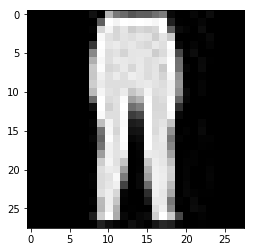

load image file: ./pytorchdata_fashionmnist/train/80.jpg, category: 1 success
Loading best model: ./pytorchdata_fashionmnist/model\fashionmnist.pt begin
Loading best model end, epoch is 10, training accuracy is 0.9507333333333333
Shape before Transorm: torch.Size([3, 28, 28])
Channel: 3, Width: 28, Height: 28
Shape after Transorm: torch.Size([1, 3, 28, 28])
tensor([1], device='cuda:0') 1
Validate user data end


In [16]:
validateuserdata()
print('Validate user data end')